In [6]:
import glob 
import numpy as np
import pylab as pl
from nptdms import TdmsFile
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import signal
import math
import pandas as pd #software library written for the Python programming language for data manipulation and analysis

In [7]:
# loading TDMS files into python editable format 

def load_tdms(tdms_path):
    '''
    TDMS data is structured in Groups and Channels.
    Each Group is divided into number of Channels (Channel 1 being the photodiode and 
    Channel 2 being the head detector)
    Group names = 'Signal_'+num
    Channel names = 'Channel_'+num
    :return: raw senor data, concatenated across groups
    TODO: allow for import of multiple sensor data
    '''

    tdms_file = TdmsFile(tdms_path)

    groups = tdms_file.groups()
    daq_signal = np.empty(1)

    for group in groups:
        chans = [c.name for c in group.channels()]
        for c in chans:
            if (c == 'Channel_1') and (group[c].properties['wf_samples'] > 0):
                daq_signal = np.hstack((daq_signal, group['Channel_1'][:]))
                
    return daq_signal

    tdms_file.close()

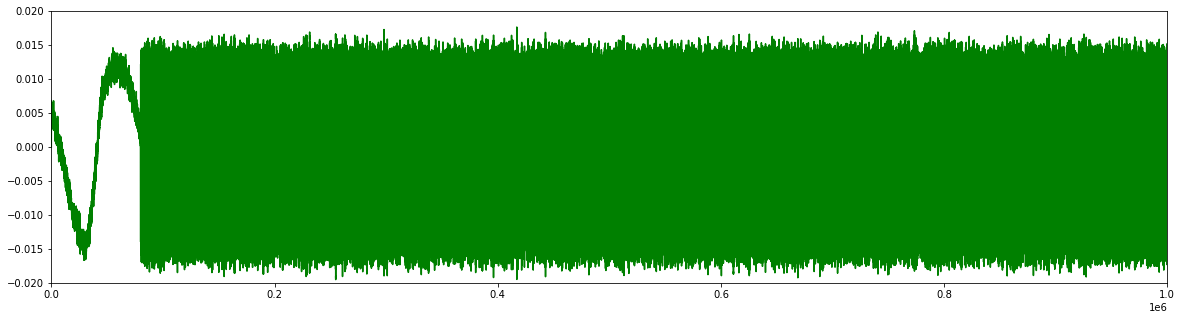

In [19]:
data = load_tdms('/Users/samjellard/STFT/2021_03_17/2021_03_17_10_46_11_50dBbessel_LO_800mV_5kHz_500kSas_LP_200pW_30mA_OD4_5_1_fullchain.tdms')


plt.figure(figsize=(20,5))
plt.plot(data[:1000000],color='g')
plt.xlim(-1, 1000000)
plt.ylim(-0.02, 0.02);


In [13]:
 #Split signal into 1024 samples, each slice will overlap by 100 samples 
from skimage import util
M = 1024
slices = util.view_as_windows(data, window_shape=(M,), step=100)
print(f'data: {data.shape}, Sliced data: {slices.shape}\n')

#Generate a windowing function and multiply it with the signal
win = np.hanning(M + 1)[:-1]
slices = slices * win
#It’s more convenient to have one slice per column, so we take the transpose:
slices = slices.T
print('Shape of slices:', slices.shape)
print (slices)

data: (46000001,), Sliced data: (459990, 1024)

Shape of slices: (1024, 459990)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.54377816e-08  5.54377816e-08  4.71077523e-08 ...  9.65134437e-08
   9.22048078e-08  8.70344448e-08]
 [ 2.22897998e-07  2.24046957e-07  1.79237566e-07 ...  3.86050141e-07
   3.92943894e-07  3.46985543e-07]
 ...
 [ 3.07628880e-07  3.85182379e-07  4.93757278e-07 ... -4.93757278e-07
  -6.17842877e-07 -7.67779642e-07]
 [ 1.34428174e-07  1.63152143e-07  2.45877173e-07 ... -2.75750101e-07
  -3.04474070e-07 -3.49283461e-07]
 [ 3.27456327e-08  4.50970555e-08  5.74484784e-08 ... -7.41085371e-08
  -8.61727176e-08 -1.01683807e-07]]


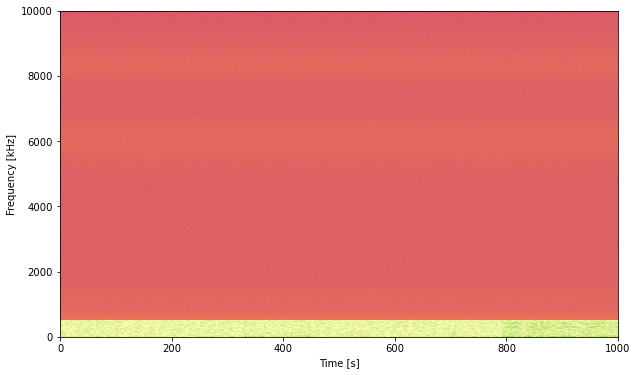

In [16]:
import matplotlib.colors as colors

spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

f, ax = plt.subplots(figsize=(10, 6)) #alter the figure size using this code

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='plasma', #colour map options:'viridis', 'plasma', 'inferno', 'magma', 'cividis' 
          extent=(0, 1000, 0, 10000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

plt.pcolormesh(S, cmap=plt.get_cmap('RdYlGn'))